In [46]:
import os
import argparse
import sys
import json
import pandas as pd
import numpy as np
import nltk
import time
from sklearn.metrics import confusion_matrix
from nltk import word_tokenize
from pandas.core.indexes.base import Index
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pickle
import random
import pkg_resources
#import somef
import seaborn as sns
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import csv
from datetime import datetime
from pathlib import Path

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ciuciu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Binary classification corrected

In [5]:
df_train = pd.read_csv('dataset/merged1.csv', sep=';')
df_train_x = df_train['Text']
for i in range(len(df_train_x)):
    df_train_x[i] = df_train_x[i].replace('\n', ' ').replace(',', ' ').lower()
df_train_y = df_train['Label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.30, random_state=42, stratify=df_train_y)

In [7]:
clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(tokenizer=<function word_tokenize at 0x7f259caa6160>)),
                ('classifier', LinearSVC(random_state=42))])

In [8]:
y_pred = clf.predict(y_test)

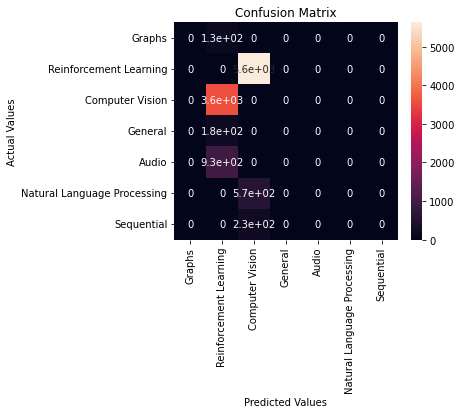

Accuracy :  0.0


In [9]:
cm = confusion_matrix(y_test, y_pred)
y_unique = y_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_unique], 
                     columns = [y_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


print("Accuracy : ", metrics.accuracy_score(y_test, y_pred))

In [10]:
x = random.randrange(0, 1000)
print(x)
X = X_test.iloc[[x]]
#print(X)
y = y_test.iloc[x]
y_pred  = clf.predict(X)
print(y, y_pred[0])

982
General General


In [11]:
df_train_all = pd.read_csv('dataset/train_all.csv', sep=';')
df_train_all_x = df_train_all['Text']
for i in range(len(df_train_all_x)):
    df_train_all_x[i] = df_train_all_x[i].replace('\n', ' ').replace(',', ' ').lower()
df_train_all_y = df_train_all['Label']
print(df_train_all.shape)

(25828, 3)


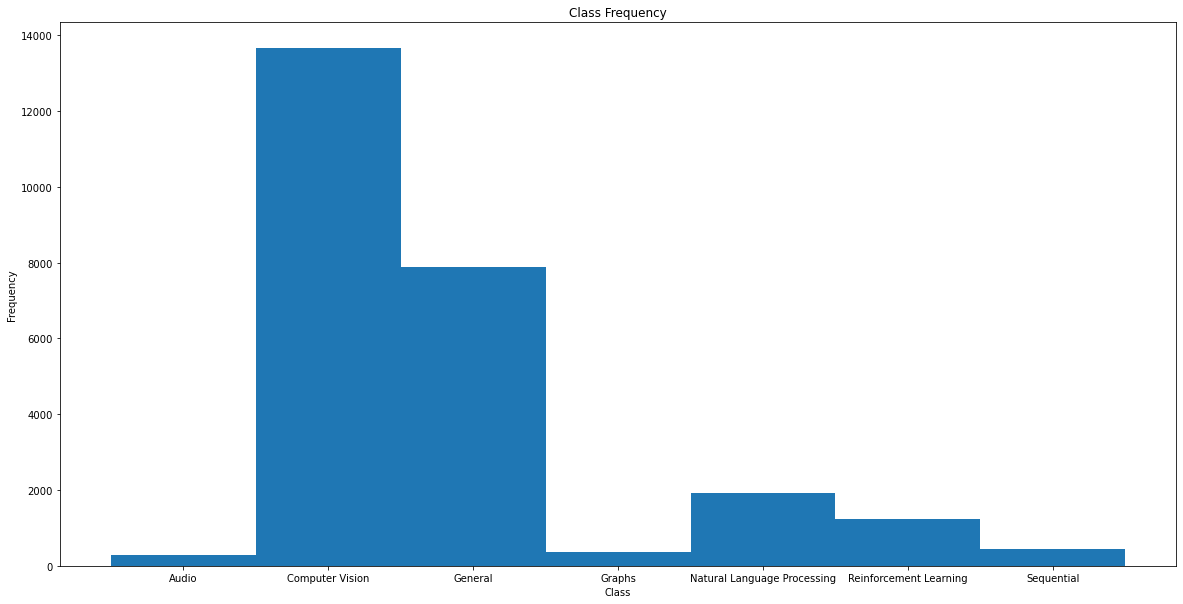

In [12]:
unique, counts = np.unique(df_train_all_y, return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [13]:
unique, counts = np.unique(df_train_all_y, return_counts=True)
print(unique)
print(counts)

['Audio' 'Computer Vision' 'General' 'Graphs'
 'Natural Language Processing' 'Reinforcement Learning' 'Sequential']
[  286 13664  7896   363  1928  1237   454]


# Nice version

In [55]:
class DataframeContainer:
    def __init__(self, name, inputFilename):
        self.name = name
        self.inputFilename = inputFilename
        self.dataframe = pd.read_csv(inputFilename, sep=';')
        
    def filter_dataframe(self):
        count = 0
        for ind, row in self.dataframe.iterrows():
            if self.name != str(row['Label']):
                count += 1
                row['Label'] = 'Other'
                row['Text'] = row['Text'].replace('\n', ' ').replace(',', ' ').lower()
        print(f'{self.name} filtered {count} rows')  

    def separate_x_y(self):
        self.df_X, self.df_y = self.dataframe['Text'], self.dataframe['Label']
        unique, counts = np.unique(self.df_y , return_counts=True)
        plt.bar(unique, counts, 1)
        plt.title('Class Frequency')
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.show()
    
    def split_train_test(self, test_size = 0.2, random_state = 42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df_X, self.df_y, test_size=test_size, random_state=random_state, stratify=self.df_y)

    def clf_fit(self):
        self.clf = Pipeline([
            ('vectorizer', CountVectorizer(analyzer="word",
                                           tokenizer=word_tokenize,
                                           max_features=None,
                                           lowercase=True)),
            ('undersample', RandomUnderSampler(sampling_strategy='majority')),
            ('classifier', LinearSVC(random_state=42))
        ])
        self.clf.fit(self.X_train, self.y_train)
        print(f'{self.name} clf fit done')
        
    def predict(self):
        self.y_pred = self.clf.predict(self.X_test)

    def confusion_matrix(self):
        y_unique = self.y_test.unique()
        cm = confusion_matrix(self.y_test, self.y_pred, labels=y_unique)
        cm_df = pd.DataFrame(cm, index = [y_unique], columns = [y_unique])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
        print(f"Accuracy {self.name} : {metrics.accuracy_score(self.y_test, self.y_pred)}")
        m = metrics.precision_recall_fscore_support(self.y_test, self.y_pred, average='macro')
        self.precision = m[0]
        self.recall = m[1]
        self.f1score = m[2]
        print(f"Precision {self.name} : {m[0]} \nRecall {self.name} : {m[1]} \nF1-score {self.name} : {m[2]}")

    def cv(self):
        scores = cross_val_score(self.clf, self.df_X, self.df_y, cv=3, scoring='f1')
        print(scores)
    
    def save_pickle(self):
        self.currentDatetime = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.pickleFilename = f"{self.name}.sav"
        Path('pickles/' + self.currentDatetime).mkdir(exist_ok=True)
        pickle.dump(self.clf, open('pickles/' + self.currentDatetime + '/' + self.pickleFilename, 'wb'))

    def printScoreboard(self):
        csvFileName = f"{self.name.lower().replace(' ', '_')}.csv"
        csvExists = os.path.exists('scoreboards/' + csvFileName)
        with open('scoreboards/' + csvFileName, 'a+') as csvfile:
            csvWriter = csv.writer(csvfile, delimiter=';')
            if not csvExists:
                csvWriter.writerow(["Pipeline", "Input", "F1 score", "Precision", "Recall", "Pickle file name", "Datetime", "Sklearn version"])
            csvWriter.writerow([self.clf.steps, self.inputFilename, self.f1score, self.precision, self.recall, self.currentDatetime + '/' + self.pickleFilename, self.currentDatetime, pkg_resources.get_distribution('sklearn').version])
            

Audio filtered 11492 rows


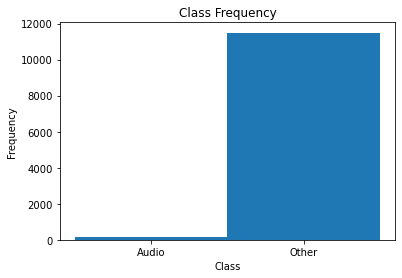

Computer Vision filtered 6535 rows


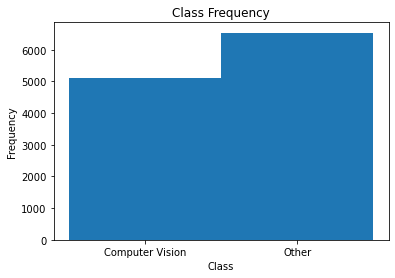

General filtered 7666 rows


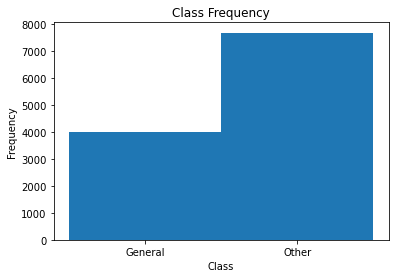

Graphs filtered 11401 rows


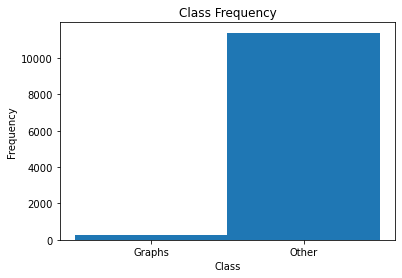

Natural Language Processing filtered 10476 rows


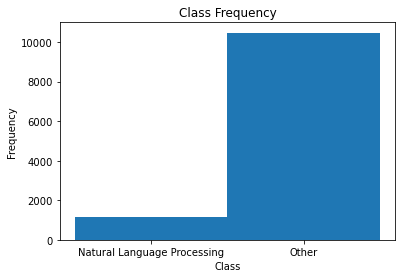

Reinforcement Learning filtered 10996 rows


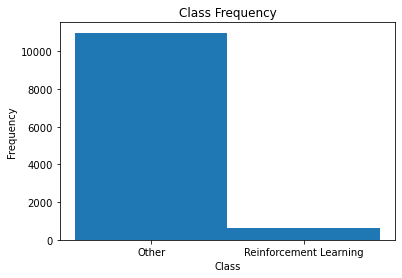

Sequential filtered 11328 rows


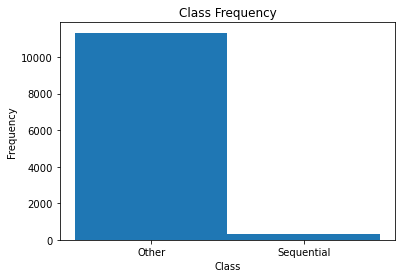

In [56]:
names_list = ["Audio", "Computer Vision", "General", "Graphs", "Natural Language Processing", "Reinforcement Learning", "Sequential"]
#names_list = ["Graphs"]
dataframecontainers_list = [DataframeContainer(name, 'dataset/somef_data1.csv') for name in names_list]
for container in dataframecontainers_list:
    container.filter_dataframe()
    container.separate_x_y()
    container.split_train_test()

In [57]:
for container in dataframecontainers_list:
    container.clf_fit()

Audio clf fit done
Computer Vision clf fit done
General clf fit done
Graphs clf fit done
Natural Language Processing clf fit done
Reinforcement Learning clf fit done
Sequential clf fit done


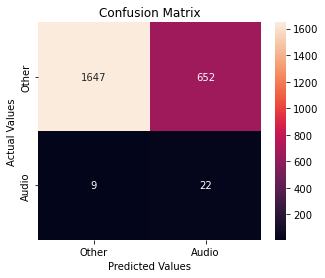

Accuracy Audio : 0.7163090128755365
Precision Audio : 0.5136030834731002 
Recall Audio : 0.7130379267283111 
F1-score Audio : 0.44764056629995247


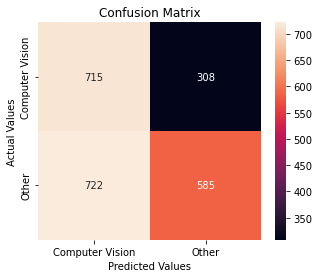

Accuracy Computer Vision : 0.5579399141630901
Precision Computer Vision : 0.576329777493082 
Recall Computer Vision : 0.5732573158591867 
F1-score Computer Vision : 0.556559497413156


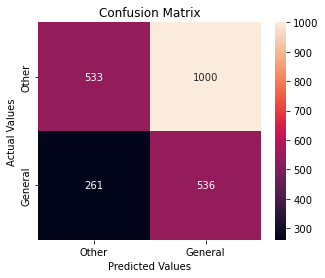

Accuracy General : 0.45879828326180255
Precision General : 0.5101214840470193 
Recall General : 0.5101031182655767 
F1-score General : 0.45879738605914167


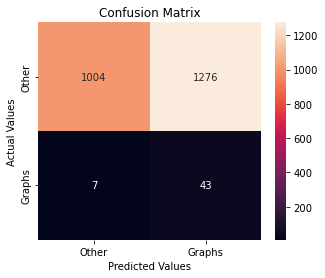

Accuracy Graphs : 0.4493562231759657
Precision Graphs : 0.5128383085528482 
Recall Graphs : 0.6501754385964912 
F1-score Graphs : 0.33648423362385277


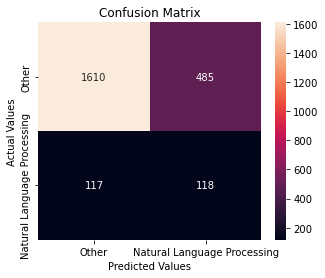

Accuracy Natural Language Processing : 0.7416309012875536
Precision Natural Language Processing : 0.5639703432269265 
Recall Natural Language Processing : 0.6353120398111003 
F1-score Natural Language Processing : 0.5620568770926767


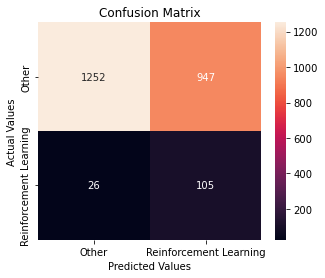

Accuracy Reinforcement Learning : 0.5824034334763949
Precision Reinforcement Learning : 0.5397327989908186 
Recall Reinforcement Learning : 0.6854382109841739 
F1-score Reinforcement Learning : 0.44883792564153624


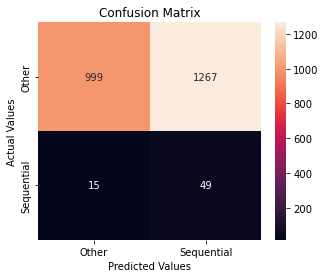

Accuracy Sequential : 0.4497854077253219
Precision Sequential : 0.5112205715724537 
Recall Sequential : 0.603244980141218 
F1-score Sequential : 0.3400804171085189


In [58]:
for container in dataframecontainers_list:
    container.predict()
    container.confusion_matrix()
    #container.cv()

In [59]:
for container in dataframecontainers_list:
    container.save_pickle()
    container.printScoreboard()

In [ ]:
def finaltest(df_train_all):
    pos = 0
    df_train_all_x = df_train_all['Text']
    for i in range(len(df_train_all_x)):
        df_train_all_x[i] = df_train_all_x[i].replace('\n', ' ').replace(',', ' ').lower()
    df_train_all_y = df_train_all['Label']
    for x in range(df_train_all_x.shape[0]):
        X = df_train_all_x.iloc[[x]]
        y = df_train_all_y.iloc[x]
        #predictions = [dataframe.clf.predict(X)[0] for dataframe in dataframecontainers_list]
        for dataframecontainer in dataframecontainers_list:
            #print(dataframecontainer.name)
            prediction = dataframecontainer.clf.predict(X)[0]
         #   p.append(prediction)
            if prediction != 'Other' and prediction == y:
                pos += 1
                break
        #print(p, y)
    print(pos/df_train_all_x.shape[0])
        
finaltest(df_train_all)

0.9969025863404057


# First try

In [18]:
df_audio = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_audio.iterrows():
    if str('Audio') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('Audio done', count)
        
df_cv = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_cv.iterrows():
    if str('Computer Vision') != str(row['Label']):
        count += 1
        row['Label'] = 'Other'
print('Computer vision done', count)
        
df_general = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_general.iterrows():
    if str('General') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('General done', count)
        
df_graphs = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_graphs.iterrows():
    if str('Graphs') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('Graphs done', count)
        
df_nlp = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_nlp.iterrows():
    if str('Natural Language Processing') != str(row['Label']):
        row['Label'] = 'Other'
        count += 1
print('NLP done', count)
        
df_rl = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_rl.iterrows():
    if str('Reinforcement Learning') != str(row['Label']):
        count += 1 
        row['Label'] = 'Other'
print('RL done', count)        

df_sequential = pd.read_csv('dataset/train_all.csv', sep=';')
count = 0
for ind, row in df_sequential.iterrows():
    if str('Sequential') != str(row['Label']):
        count += 1
        row['Label'] = 'Other'
print('Seqential done', count)

Audio done 25542
Computer vision done 12164
General done 17932
Graphs done 25465
NLP done 23900
RL done 24591
Seqential done 25374


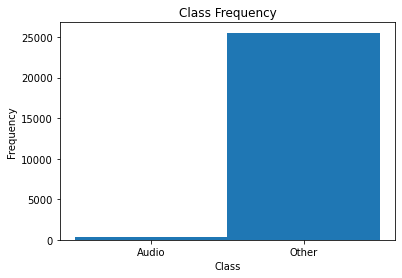

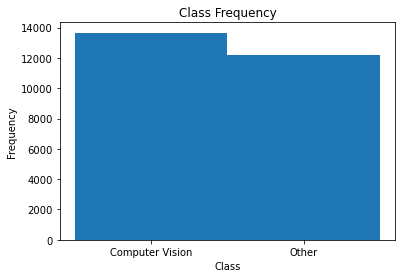

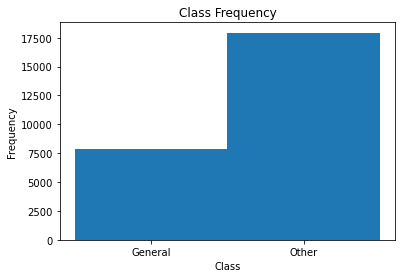

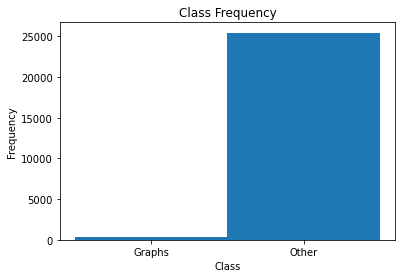

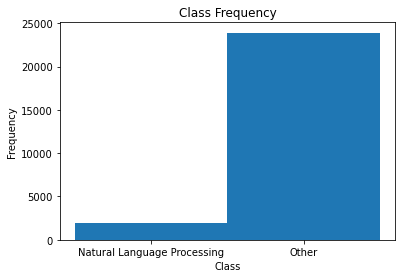

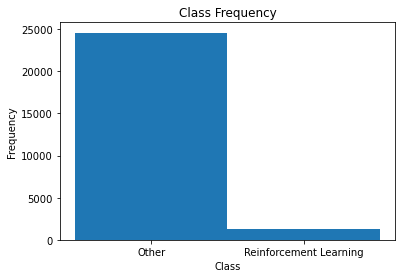

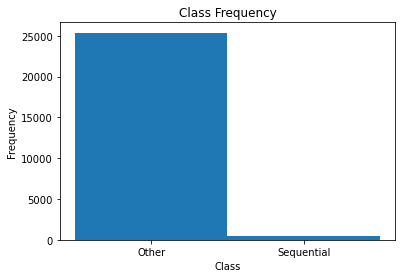

In [19]:
df_audio_x = df_audio['Text']
df_audio_y = df_audio['Label']

unique, counts = np.unique(df_audio_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_cv_x = df_cv['Text']
df_cv_y = df_cv['Label']

unique, counts = np.unique(df_cv_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_general_x = df_general['Text']
df_general_y = df_general['Label']

unique, counts = np.unique(df_general_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_graphs_x = df_graphs['Text']
df_graphs_y = df_graphs['Label']

unique, counts = np.unique(df_graphs_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_nlp_x = df_nlp['Text']
df_nlp_y = df_nlp['Label']

unique, counts = np.unique(df_nlp_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_rl_x = df_rl['Text']
df_rl_y = df_rl['Label']

unique, counts = np.unique(df_rl_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


df_sequential_x = df_sequential['Text']
df_sequential_y = df_sequential['Label']

unique, counts = np.unique(df_sequential_y , return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [20]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(df_audio_x, df_audio_y, test_size=0.30, random_state=42, stratify=df_audio_y)

X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(df_cv_x, df_cv_y, test_size=0.30, random_state=42, stratify=df_cv_y)

X_general_train, X_general_test, y_general_train, y_general_test = train_test_split(df_general_x, df_general_y, test_size=0.30, random_state=42, stratify=df_general_y)

X_graphs_train, X_graphs_test, y_graphs_train, y_graphs_test = train_test_split(df_graphs_x, df_graphs_y, test_size=0.30, random_state=42, stratify=df_graphs_y)

X_nlp_train, X_nlp_test, y_nlp_train, y_nlp_test = train_test_split(df_nlp_x, df_nlp_y, test_size=0.30, random_state=42, stratify=df_nlp_y)

X_rl_train, X_rl_test, y_rl_train, y_rl_test = train_test_split(df_rl_x, df_rl_y, test_size=0.30, random_state=42, stratify=df_rl_y)

X_sequential_train, X_sequential_test, y_sequential_train, y_sequential_test = train_test_split(df_sequential_x, df_sequential_y, test_size=0.30, random_state=42, stratify=df_sequential_y)

In [21]:
clf_audio = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_audio.fit(X_audio_train, y_audio_train)
print('Audio done')


clf_cv = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_cv.fit(X_cv_train, y_cv_train)
print('CV done')


clf_general = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_general.fit(X_general_train, y_general_train)
print('General done')


clf_graphs = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_graphs.fit(X_graphs_train, y_graphs_train)
print('Graphs done')


clf_nlp = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_nlp.fit(X_nlp_train, y_nlp_train)
print('NLP done')


clf_rl = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_rl.fit(X_rl_train, y_rl_train)
print('RL done')


clf_sequential = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   max_features=None,
                                   lowercase=True)),
    #('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42))
])
clf_sequential.fit(X_sequential_train, y_sequential_train)
print('Sequential done')

Audio done
CV done
General done
Graphs done
NLP done
RL done
Sequential done


In [22]:
y_audio_pred = clf_audio.predict(X_audio_test)

y_cv_pred = clf_cv.predict(X_cv_test)

y_general_pred = clf_general.predict(X_general_test)

y_graphs_pred = clf_graphs.predict(X_graphs_test)

y_nlp_pred = clf_nlp.predict(X_nlp_test)

y_rl_pred = clf_rl.predict(X_rl_test)

y_sequential_pred = clf_sequential.predict(X_sequential_test)

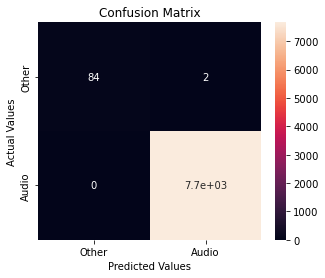

Accuracy audio :  0.9997419021809266


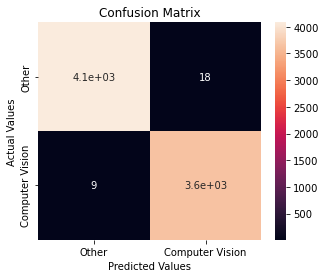

Accuracy cv :  0.9965156794425087


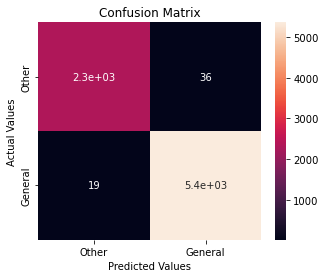

Accuracy general :  0.9929023099754807


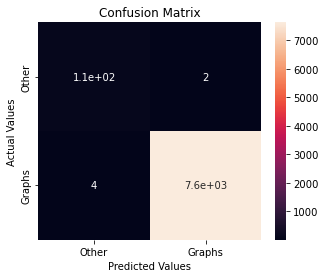

Accuracy graphs :  0.9992257065427798


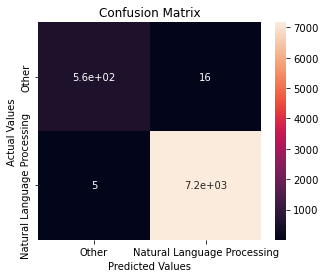

Accuracy nlp :  0.997289972899729


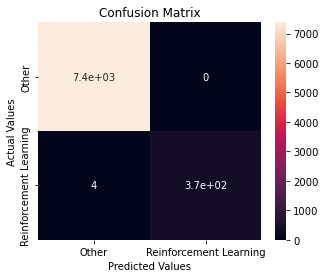

Accuracy rl :  0.9994838043618531


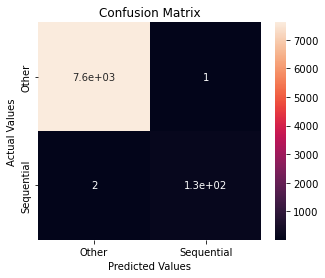

Accuracy sequential :  0.9996128532713898


In [23]:
cm = confusion_matrix(y_audio_test, y_audio_pred)
y_audio_unique = y_audio_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_audio_unique], 
                     columns = [y_audio_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy audio : ", metrics.accuracy_score(y_audio_test, y_audio_pred))


cm = confusion_matrix(y_cv_test, y_cv_pred)
y_cv_unique = y_cv_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_cv_unique], 
                     columns = [y_cv_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy cv : ", metrics.accuracy_score(y_cv_test, y_cv_pred))


cm = confusion_matrix(y_general_test, y_general_pred)
y_general_unique = y_general_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_general_unique], 
                     columns = [y_general_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy general : ", metrics.accuracy_score(y_general_test, y_general_pred))


cm = confusion_matrix(y_graphs_test, y_graphs_pred)
y_graphs_unique = y_graphs_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_graphs_unique], 
                     columns = [y_graphs_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy graphs : ", metrics.accuracy_score(y_graphs_test, y_graphs_pred))


cm = confusion_matrix(y_nlp_test, y_nlp_pred)
y_nlp_unique = y_nlp_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_nlp_unique], 
                     columns = [y_nlp_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy nlp : ", metrics.accuracy_score(y_nlp_test, y_nlp_pred))


cm = confusion_matrix(y_rl_test, y_rl_pred)
y_rl_unique = y_rl_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_rl_unique], 
                     columns = [y_rl_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy rl : ", metrics.accuracy_score(y_rl_test, y_rl_pred))


cm = confusion_matrix(y_sequential_test, y_sequential_pred)
y_sequential_unique = y_sequential_test.unique()
cm_df = pd.DataFrame(cm,
                     index = [y_sequential_unique], 
                     columns = [y_sequential_unique])#
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print("Accuracy sequential : ", metrics.accuracy_score(y_sequential_test, y_sequential_pred))

In [24]:
pos = 0
for x in range(df_train_all_x.shape[0]):
    predictions = []
    X = df_train_all_x.iloc[[x]]
    y = df_train_all_y.iloc[x]
    predictions.append(clf_audio.predict(X)[0])
    predictions.append(clf_cv.predict(X)[0])
    predictions.append(clf_general.predict(X)[0])
    predictions.append(clf_graphs.predict(X)[0])
    predictions.append(clf_nlp.predict(X)[0])
    predictions.append(clf_rl.predict(X)[0])
    predictions.append(clf_sequential.predict(X)[0])
    for i in predictions:
        if i != 'Other':
            if i == y:
                pos += 1
                continue
print(pos/df_train_all_x.shape[0])

KeyboardInterrupt: 